# Initialization

In [1]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

from time import sleep, monotonic, time
import datetime as dt

import qcodes as qc
from qcodes import Parameter
from qcodes import initialise_or_create_database_at
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.measurements import Measurement

sys.path.append("C:/Users/TUD206951/Documents/Local_QCoDeS/scripts")
from sweeps import do1d, do2d, time_sweep, measure_until, do1d_until

import warnings
warnings.filterwarnings('ignore')

To modify list of instruments, eddit file
"C:\Users\TUD206951\Documents\Local_QCoDeS\scripts\init_Gecko.py"

In [2]:
fridge_name = 'Gecko'
%run C:\Users\TUD206951\Documents\Local_QCoDeS\scripts\init_fridge.py {fridge_name}

Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:1330543, firmware:A20  /A02) in 0.26s


[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:4107614, firmware:B01  /A02) in 0.08s


[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Connected to: Stanford_Research_Systems SR830 (serial:s/n47557, firmware:ver1.07) in 0.06s
Connected to: Stanford_Research_Systems SR830 (serial:s/n43309, firmware:ver1.07) in 0.05s
Connected to: LSCI 332S (serial:332557, firmware:112002) in 0.03s
Initialized IVVI-rack in 0.02s


Here are all the instruments we have:

In [3]:
station.components

{'keithley_1': <Keithley_2000: keithley_1>,
 'keithley_2': <Keithley_2000: keithley_2>,
 'lockin_1': <SR830: lockin_1>,
 'lockin_2': <SR830: lockin_2>,
 'lakeshore': <Model_332: lakeshore>,
 'ivvi': <IVVI: ivvi>}

Zero dacs and lockin

In [4]:
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)

## DAC rates

Change the dac rate (same idea as with qtlab, but two commands are used)

In [5]:
ivvi.dac1.step = 50
ivvi.dac1.inter_delay = 0.05
ivvi.dac2.step = 50
ivvi.dac2.inter_delay = 0.05
ivvi.dac3.step = 4
ivvi.dac3.inter_delay = 0.2

## Database initialisation

Next, we create a qcodes database, or we can use the existing one

In [6]:
#useful if you want to name database with creation date
date = str(dt.date.today())
db_path = "C:/Users/TUD206951/Documents/LOCAL_DATA/Alberto/PbTe_2GN"
initialise_or_create_database_at(db_path + "/" + "PbTe_2GN.db" )

# Scaled parameters

It is more convenient to use meaningful parameters with correct units

In [7]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters. Run ONLY ONCE!

In [8]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1000 / TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
# Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
# station.add_component(Gain_L2)

'Gain_L1'

## IVVI rack parameters - UPDATE here DURING measuerements

Also can be coppied to execute later

In [96]:
Irange.set(100e-9)
Vrange.set(100e-3)
TGrange.set(15)
Gain_K1.set(1e6)
Gain_K2.set(1e6)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
# Gain_L2.set(Gain_K2())

#division parameters are updated automatically

## DC parameters - assigning devices. RUN ONLY ONCE!
Check that devicies are correct!

In [10]:
appl_current = ScaledParameter(ivvi.dac1, division = Irange_division, name = 'appl_current', unit = 'A')
appl_voltage = ScaledParameter(ivvi.dac2, division = Vrange_division, name = 'appl_voltage', unit = 'V')
appl_TG = ScaledParameter(ivvi.dac3, division = TGrange_division, name = 'appl_TG', unit = 'V')

meas_voltage_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_voltage_K1', unit = 'V')
meas_voltage_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')
# meas_voltage_K3 = ScaledParameter(keithley_3.amplitude, division = Gain_K3, name = 'meas_voltage_K3', unit = 'V')
meas_leakage = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')

meas_current_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_current_K1', unit = 'A')
meas_current_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')
# meas_current_K3 = ScaledParameter(keithley_3.amplitude, division = Gain_K3, name = 'meas_current_K3', unit = 'A')

station.add_component(appl_current)
station.add_component(appl_voltage)
station.add_component(appl_TG)
station.add_component(meas_voltage_K1)
station.add_component(meas_voltage_K2)
# station.add_component(meas_voltage_K3)
station.add_component(meas_leakage)
station.add_component(meas_current_K1)
station.add_component(meas_current_K2)
# station.add_component(meas_current_K3)

'meas_current_K2'

Reasining devices seems to be missing in public methods of ScaledParameter class... But you can try:

In [11]:
# appl_current._wrapped_parameter = ivvi.dac1

## AC parameters

In [12]:
appl_current_AC = ScaledParameter(lockin_1.amplitude, division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')
appl_voltage_AC = ScaledParameter(lockin_1.amplitude, division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')

station.add_component(appl_current_AC)
station.add_component(appl_voltage_AC)

meas_voltage_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_voltage_Lockin1', unit = 'V')

meas_current_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_current_Lockin1', unit = 'A')

station.add_component(meas_voltage_AC_L1)
station.add_component(meas_current_AC_L1)

'meas_current_Lockin1'

## Another useful example: magnet using dac (Janis)

>2231.2 G per A => 0.22312 T per A<br>
I source 10mA per V => 1e-5 A per 1mV<br>
result: 0.22312 T/A * 1e-5 A/mV

In [13]:
#magnetic_field = ScaledParameter(ivvi.dac3, gain = 0.22312e-5, name = 'magnetic_field_dac', unit = 'T')
#station.add_component(magnetic_field)

# Fidge controll.

In [14]:
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)

In [ ]:
lakeshore.heater_output.setpoint(2)

In [ ]:
print('Temps: A= {:.2f}'.format(lakeshore.A.temperature()) )

# Standard sweeps: setting parameter

## 1D sweeps

In [110]:
# current_AC(1e-6)
ivvi.set_dacs_zero()
exp = qc.new_experiment('IV-curve', sample_name='L9-L10 conduction test')
dataid = do1d(appl_voltage, 0, 0.1e-3, 200, 0.2, meas_current_K1)
#sweep current from -10uA to 10uA 100 points with 0.2sec delay
#records voltage on keithley and lockin
ivvi.set_dacs_zero()

Starting experimental run with id: 110. 


  0%|          | 0/200 [00:00<?, ?it/s]

In [85]:
ivvi.set_dacs_zero()

### Plotting

In [ ]:
plot_by_id(dataid)

### Plotting later using list of experiments

In [ ]:
qc.experiments()

In [ ]:
dataset = qc.load_by_id(1)
plot_dataset(dataset)

## 2D sweeps

In [ ]:
exp = qc.new_experiment('IV-curve_vs_dac5', sample_name='simulator_100_Ohm')
dataid = do2d(ivvi.dac5, -1, 1, 3, 5, current, -10e-6, 10e-6, 100, 0.2, voltage_DC)
#sweep current from -10uA to 10uA 100 points with 0.2sec delay
#records voltage on keithley and lockin
ivvi.set_dacs_zero()

In [ ]:
plot_by_id(dataid)

In [ ]:
cmap = plt.get_cmap('hot')
plot_by_id(dataid, cmap = cmap)
plt.savefig('../plots/iv_vs_dac5.pdf')

# Standard sweeps: measuring without setting value

## Measured values versus non-setable parameter

In [ ]:
time = ElapsedTimeParameter('time')

def time_limit(time, measured_values):
    return time() > 6

In [ ]:
exp = qc.new_experiment('V_vs_time', sample_name='simulator_100_Ohm')
current(10e-6)
current_AC(1e-6)
time.reset_clock()
dataid = measure_until(time, time_limit, 1, voltage_DC, voltage_AC)

In [ ]:
plot_by_id(dataid)

## Useful for temperature scans and magnet sweeps:

In [ ]:
def temp_limit(temp, measured_values):
    return temp() < 0.4

exp = qc.new_experiment('V_vs_temp_CD', sample_name='simulator_100_Ohm')
current(10e-6)
current_AC(1e-6)
dataid = measure_until(lakeshore.A.temperature, temp_limit, 1, voltage_DC, voltage_AC)

### Exit based on measured value

In [ ]:
def voltage_limit(time, measured_values):
    return measured_values[0].get() > -0.94e-3

exp = qc.new_experiment('V_vs_time', sample_name='simulator_100_Ohm')
current(10e-6)
current_AC(1e-6)
time = ElapsedTimeParameter('time')
time.reset_clock()
dataid = measure_until(time, voltage_limit, 1, voltage_DC, voltage_AC)

In [ ]:
ivvi.dac3(-1300)

In [ ]:
plot_by_id(dataid)

## 1D scan vs non-setable parameter

In [ ]:
time = ElapsedTimeParameter('time')

#note that here exit_condition takes two independent parameters and only then measured parameters
def time_limit(time, current, measured_values):
    return time() > 30

exp = qc.new_experiment('IV_vs_time', sample_name='simulator_100_Ohm')
current_AC(0.04e-6)
time.reset_clock()
dataid = do1d_until(time, time_limit, 1, current, -10e-6, 10e-6, 100, 0.2, voltage_DC)

In [ ]:
cmap = plt.get_cmap('hot')
plot_by_id(dataid, cmap = cmap)

# Custom sweeps

## Gate sweep controlling the leakage

Starting experimental run with id: 114. 


  0%|          | 0/500 [00:00<?, ?it/s]

([<AxesSubplot:title={'center':'Run #114, Experiment V_vs_Vgate (NW22_50mV)'}, xlabel='appl_TG (V)', ylabel='meas_current_K1 (pA)'>,
  <AxesSubplot:title={'center':'Run #114, Experiment V_vs_Vgate (NW22_50mV)'}, xlabel='appl_TG (V)', ylabel='meas_leakage (nA)'>],
 [None, None])

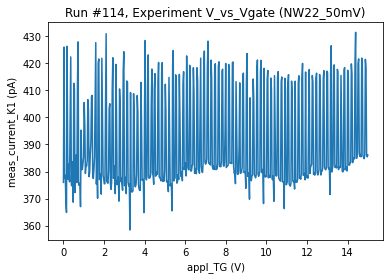

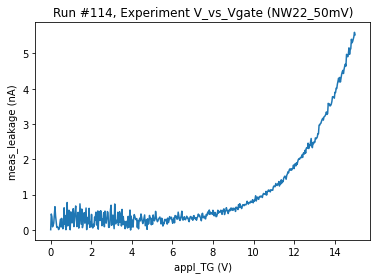

In [116]:
exp = qc.new_experiment('V_vs_Vgate', sample_name='NW22_50mV')
appl_voltage(50e-3)

start_gate = 0
stop_gate = 15
num_points = 500
leak_threshold = 15.0e-9

#Register independent parameters
meas = Measurement()
meas.register_parameter(appl_TG)
appl_TG.post_delay = 0.1

#Register dependent parametrs
param_meas = [meas_current_K1, meas_leakage]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(appl_TG,))
    output.append([parameter, None])

#Add action at the end
# meas.add_after_run(ivvi.set_dacs_zero, ())

appl_TG(start_gate)
#Start measuremnts
with meas.run() as datasaver:
    for set_point in tqdm(np.linspace(start_gate, stop_gate, num_points)):
        appl_TG(set_point)
        sleep(0.5)
        if np.abs(meas_leakage()) > leak_threshold:
            print('Leakage detected!')
            print('Detected current: {}A'.format(meas_leakage()))
            break
        for i, parameter in enumerate(param_meas):
            output[i][1] = np.abs(parameter.get())
        datasaver.add_result((appl_TG, appl_TG()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting
plot_by_id(dataid)

In [29]:
appl_voltage(1e-3)

In [117]:
ivvi.set_dacs_zero()

## Bias sweep controlling the leakage

Starting experimental run with id: 113. 


  0%|          | 0/500 [00:00<?, ?it/s]

([<AxesSubplot:title={'center':'Run #113, Experiment V_vs_Vbias (NW17_15V)'}, xlabel='appl_voltage (mV)', ylabel='meas_current_K1 (pA)'>,
  <AxesSubplot:title={'center':'Run #113, Experiment V_vs_Vbias (NW17_15V)'}, xlabel='appl_voltage (mV)', ylabel='meas_leakage (nA)'>],
 [None, None])

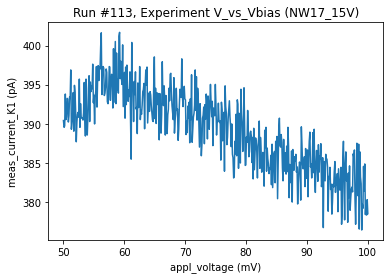

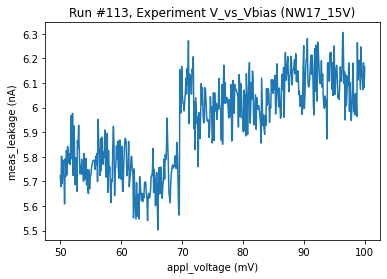

In [114]:
exp = qc.new_experiment('V_vs_Vbias', sample_name='NW17_15V')

appl_voltage(0)
sleep(5)

start_bias = 50e-3
stop_bias= 100e-3
num_points = 500
leak_threshold = 15.0e-9

#Register independent parameters
meas = Measurement()
meas.register_parameter(appl_voltage)
appl_voltage.post_delay = 0.1

#Register dependent parametrs
param_meas = [meas_current_K1, meas_leakage]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(appl_voltage,))
    output.append([parameter, None])

#Add action at the end
# meas.add_after_run(ivvi.set_dacs_zero, ())


#Start measuremnts
with meas.run() as datasaver:
    for set_point in tqdm(np.linspace(start_bias, stop_bias, num_points)):
        appl_voltage(set_point)
        sleep(0.1)
        if np.abs(meas_leakage()) > leak_threshold:
            print('Leakage detected!')
            print('Detected current: {}A'.format(meas_leakage()))
            break
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((appl_voltage, appl_voltage()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting
plot_by_id(dataid)

In [115]:
ivvi.set_dacs_zero()


# Snapshots

In [ ]:
dataset = qc.load_by_id(1)
dataset.snapshot['station']

In [ ]:
dataset.snapshot['station']['parameters']['current_AC']

In [ ]:
dataset.snapshot['station']['instruments']['ivvi']

In [ ]:
pprint(diff_param_values(qc.load_by_id(1).snapshot, qc.load_by_id(2).snapshot).changed)